<a href="https://colab.research.google.com/github/EliasNoorzad/Pose6d_project/blob/main/models/training_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading packages

In [ ]:
!pip install trimesh
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.0/712.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Mounting to Google Drive

In [ ]:
import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'path/to/my/project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


## Creating custom dataset

In [ ]:
# Standard libraries.
import os
import yaml
import numpy as np
import json

# PyTorch and image processing.
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset(Dataset):
    """
    Custom PyTorch dataset for loading RGB images, camera intrinsics,
    3D object models, and 6D pose annotations from the LineMOD dataset.
    """

    def __init__(self, dataset_root,
                 models_root,
                 folders=list(range(1, 16)),
                 split='train',
                 val_ratio=0.8,
                 seed=42,
                 img_size=(224, 224)):
        """
        Initializes the dataset by reading object annotations, images,
        and preparing train/test splits.

        Args:
            dataset_root (str): Root path to LineMOD dataset.
            models_root (str): Path to 3D object models and models_info.yml.
            folders (list): List of object IDs (integers from 1 to 15).
            split (str): Either 'train' or 'test'.
            train_ratio (float): Proportion of data used for training.
            seed (int): Random seed for reproducibility.
            img_size (tuple): Target image size for input to neural network.
        """
        self.dataset_root = dataset_root
        self.models_root = models_root
        self.split = split
        self.val_ratio = val_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}  # Cache for loaded 3D models.
        self.invalid_entries = 0

        # Load object-specific metadata.
        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.safe_load(f)

        # Cache ground truth and camera info per object.
        self.gt_data = {}
        self.info_data = {}
        self.all_samples = []  # List of (object_id, sample_id) tuples.

        for obj_id in folders:
            obj_folder = os.path.join(dataset_root, f"{obj_id:02d}")
            gt_path = os.path.join(obj_folder, 'gt.yml')
            info_path = os.path.join(obj_folder, 'info.yml')

            if not os.path.exists(gt_path):
                continue

            # Load ground truth and camera intrinsic data.
            with open(gt_path, 'r') as f:
                gt = yaml.safe_load(f)
            with open(info_path, 'r') as f:
                info = yaml.safe_load(f)

            self.gt_data[obj_id] = gt
            self.info_data[obj_id] = info

            for sample_id in gt.keys():
                self.all_samples.append((obj_id, int(sample_id)))

        # Map original object IDs to index values with start 0 and incrementing order.
        object_id_set = set()
        for obj_id, sample_id in self.all_samples:
            for ann in self.gt_data[obj_id][sample_id]:
                object_id_set.add(ann['obj_id'])

        self.object_ids = sorted(object_id_set)
        self.id_to_idx = {obj_id: i for i, obj_id in enumerate(self.object_ids)}
        self.idx_to_id = {i: obj_id for obj_id, i in self.id_to_idx.items()}

        if not self.all_samples:
            raise ValueError(f"No samples found in {dataset_root}. Check dataset structure.")

        # Split into train/test subsets.
        #train, test = train_test_split(self.all_samples, train_size=self.train_ratio, random_state=self.seed)
        #self.samples = train if self.split == 'train' else test

        # Split filtering using per-object train/test.txt.
        selected_samples = []
        for obj_id in folders:
            obj_folder = os.path.join(dataset_root, f"{obj_id:02d}")
            split_file = 'train.txt' if self.split == 'train' else 'test.txt'
            split_path = os.path.join(obj_folder, split_file)

            if not os.path.exists(split_path):
                print(f"⚠️ Warning: Missing {split_file} in folder {obj_id:02d}, skipping.")
                continue

            # Load sample IDs from the split file.
            with open(split_path, 'r') as f:
                all_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

            # Perform internal split on test set if needed
            if self.split in ['val', 'test']:
                np.random.seed(self.seed)
                np.random.shuffle(all_ids)

                split_index = int(self.val_ratio * len(all_ids))

                if self.split == 'val':
                    selected_ids = all_ids[:split_index]
                else:  # for 'test'.
                    selected_ids = all_ids[split_index:]
            else:
                selected_ids = all_ids  # for 'train'.

            for sample_id in selected_ids:
                selected_samples.append((obj_id, sample_id))

        self.samples = [s for s in self.all_samples if s in selected_samples]

        # Image preprocessing pipeline.
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.samples)

    def save_mapping(self, filepath=None):
        """Saves object ID to index mapping to a JSON file."""
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "w") as f:
            json.dump(self.id_to_idx, f)

    @staticmethod
    def load_mapping(filepath=None):
        """Loads a previously saved object ID mapping from file."""
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "r") as f:
            mapping = json.load(f)
        return {int(k): v for k, v in mapping.items()}

    def printIDMapping(self):
        """Prints object ID mapping from original ID to training index."""
        print("Object ID Mapping (Original → Mapped):")
        for orig_id in self.object_ids:
            print(f"  {orig_id:02d} → {self.id_to_idx[orig_id]}")

    def nrInvalidObjects(self):
        """Returns number of invalid bounding boxes encountered during cropping."""
        return self.invalid_entries

    def getMappedIDs(self, ids=None):
        """
        Maps original object IDs to their training indices.

        Args:
            ids (list or None): Original object IDs. If None, returns all mappings.
        Returns:
            mapped_ids (list): Mapped training indices.
            orig_ids (list): Corresponding original object IDs.
        """
        mapped_ids = []
        orig_ids = []
        if ids is None:
            for orig_id in self.object_ids:
                mapped_ids.append(self.id_to_idx[orig_id])
                orig_ids.append(orig_id)
        else:
            for id in ids:
                if id in self.id_to_idx:
                    mapped_ids.append(self.id_to_idx[id])
                    orig_ids.append(id)
                else:
                    print(f"⚠️ Warning: Object ID {id} not found in dataset and will be ignored.")
        return mapped_ids, orig_ids

    def get_model_info(self, object_id):
        """Returns metadata (ex. diameter) for the specified object ID."""
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not in models_info.yml")
        return self.models_info[object_id]

    def load_3D_model(self, object_id):
        """
        Loads and returns the 3D model (in meters) of the specified object.
        Caches the result to avoid redundant loading.
        """
        if object_id in self.models:
            return self.models[object_id]

        model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
        mesh = trimesh.load(model_path)
        points = mesh.vertices.astype(np.float32) / 1000.0  # mm -> m
        self.models[object_id] = points
        return points

    def cropImages(self, image, annotations, cam_K):
        """
        Crops object regions from the image based on bounding boxes and adjusts the intrinsics.

        Args:
            image (PIL.Image): Original RGB image.
            annotations (list): Object annotations from gt.yml.
            cam_K (torch.Tensor): Original 3x3 camera intrinsic matrix.

        Returns:
            crop_entries (list): List of cropped image entries with adjusted intrinsics.
            cam_K (torch.Tensor): Original intrinsic matrix.
        """
        crop_entries = []
        width, height = image.size

        for ann in annotations:
            x, y, w, h = ann['obj_bb']
            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(width, x + w)
            y2 = min(height, y + h)

            # Skip invalid bounding boxes.
            if x2 <= x1 or y2 <= y1:
                self.invalid_entries += 1
                continue

            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            # Adjust intrinsics for crop and resize.
            cropped_K = cam_K.clone()
            cropped_K[0, 2] -= x1
            cropped_K[1, 2] -= y1

            cropped = cropped.resize(self.img_size, Image.BILINEAR)
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height
            cropped_K[0, 0] *= scale_x
            cropped_K[0, 2] *= scale_x
            cropped_K[1, 1] *= scale_y
            cropped_K[1, 2] *= scale_y

            cropped_rgb_tensor = self.transform(cropped)
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000.0  # mm → m

            # Normalized bounding box.
            norm_bbox = torch.tensor([
                x1 / width,
                y1 / height,
                (x2 - x1) / width,
                (y2 - y1) / height
            ], dtype=torch.float32)

            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': ann['obj_bb'],
                'norm_bbox': norm_bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, cam_K

    def __getitem__(self, idx):
        """
        Loads a data sample consisting of:
        - Original RGB image.
        - Camera intrinsics.
        - List of cropped objects with adjusted intrinsics and pose labels.
        """
        object_id, sample_id = self.samples[idx]
        folder = os.path.join(self.dataset_root, f"{object_id:02d}")

        rgb_path = os.path.join(folder, 'rgb', f"{sample_id:04d}.png")
        if not os.path.exists(rgb_path):
            raise FileNotFoundError(f"RGB image not found: {rgb_path}")
        rgb = Image.open(rgb_path).convert("RGB")

        annotations = self.gt_data[object_id][sample_id]
        cam_K = torch.tensor(np.array(self.info_data[object_id][sample_id]['cam_K']).reshape(3, 3), dtype=torch.float32)

        crop_entries, org_K = self.cropImages(rgb, annotations, cam_K)

        # Remap object IDs from original to training indices.
        for entry in crop_entries:
            true_obj_id = entry['object_id']
            if true_obj_id not in self.id_to_idx:
                raise ValueError(f"Object ID {true_obj_id} not found in id_to_idx mapping.")
            entry['object_id'] = self.id_to_idx[true_obj_id]

        return {
            'sample_id': sample_id,
            'original_rgb': rgb,
            'original_K': org_K,
            'objects': crop_entries
        }

## PoseNet6D with ResNet18

In [ ]:
from torch import nn
import torch
import torch.nn.functional as F
# Loading the resnet18 model together with pre-trained weights.
from torchvision.models import resnet18, ResNet18_Weights


class PoseNet6D(nn.Module):
    """
    PoseNet6D estimates 6D object pose (translation and rotation) from cropped RGB images,
    using a CNN backbone (ResNet18), bounding box information, and object ID embeddings.
    """
    def __init__(self, num_objects,
                 embedding_dim=16,
                 img_size=(224, 224),
                 weights=ResNet18_Weights.DEFAULT):
        """
        Initializes the network components.

        Args:
            num_objects (int): Number of unique object classes.
            embedding_dim (int): Size of the object ID embedding vector.
            img_size (tuple): Size of the input images (width, height).
            weights (ResNet18_Weights): Pretrained weights for ResNet18 backbone.
        """
        super(PoseNet6D, self).__init__()
        self.img_size = img_size

        # Load pretrained ResNet18 and remove the last two layers.
        resnet = resnet18(weights=weights)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7).

        # Global average pooling to reduce spatial features to vector.
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Object ID embedding layer.
        self.obj_embedding = nn.Embedding(num_embeddings=num_objects,
                                          embedding_dim=embedding_dim)

        # Concatenated feature size: image (512) + bbox (4) + object embedding.
        tot_dim = 512 + 4 + embedding_dim

        # Fully connected layers for depth estimation.
        self.fc_depth = nn.Sequential(
            nn.Linear(tot_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Fully connected layers for quaternion rotation.
        self.fc_rotation = nn.Sequential(
            nn.Linear(tot_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x_img, norm_bbox, K_crop, object_id):
        """
        Forward pass to estimate translation and rotation.

        Args:
            x_img (Tensor): Input cropped RGB image (B, 3, H, W).
            norm_bbox (Tensor): Normalized bounding boxes (B, 4).
            K_crop (Tensor): Intrinsics matrix adjusted to crop (B, 3, 3).
            object_id (Tensor): Object class indices (B,).

        Returns:
            translation (Tensor): Estimated 3D translation vector (B, 3).
            quat (Tensor): Estimated rotation quaternion (B, 4).
        """
        B = x_img.shape[0]

        # CNN feature extraction.
        x = self.backbone(x_img)                # Shape: (B, 512, 7, 7)
        x = self.global_pool(x).view(B, -1)     # Shape: (B, 512)

        # Ensure object IDs are on the correct device.
        object_id = object_id.to(self.obj_embedding.weight.device)

        # Object embedding.
        obj_feat = self.obj_embedding(object_id)

        # Concatenate image features, bbox, and object embedding.
        x = torch.cat([x, norm_bbox, obj_feat], dim=1)  # Shape: (B, tot_dim)

        # Predict object depth (z).
        depth = self.fc_depth(x).squeeze(1)  # Shape: (B,)
        depth = torch.clamp(depth, min=0.1, max=1.5)  # Clamping to avoid extreme values.

        # Predict object orientation as a unit quaternion.
        quat = F.normalize(self.fc_rotation(x), dim=1)  # Shape: (B, 4)

        # Deproject normalized bbox center to camera coordinates using intrinsics.
        fx = K_crop[:, 0, 0]
        fy = K_crop[:, 1, 1]
        cx_crop = K_crop[:, 0, 2]
        cy_crop = K_crop[:, 1, 2]

        img_w, img_h = self.img_size
        u = (norm_bbox[:, 0] + 0.5 * norm_bbox[:, 2]) * img_w  # Center x
        v = (norm_bbox[:, 1] + 0.5 * norm_bbox[:, 3]) * img_h  # Center y

        # Back-project to 3D camera coordinates.
        x_cam = (u - cx_crop) * depth / fx
        y_cam = (v - cy_crop) * depth / fy
        z_cam = depth

        translation = torch.stack([x_cam, y_cam, z_cam], dim=1)  # Shape: (B, 3)
        return translation, quat

## Helper functions

In [ ]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree
import numpy as np
import torch

# -----------------------------
# ADD Metric (Average Distance to Model Points)
# -----------------------------
def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    """
    Computes the ADD (Average Distance of Model Points) metric.
    Measures the mean distance between predicted and ground-truth transformed model points.

    Args:
        R_pred (ndarray or Tensor): Predicted rotation matrix (3x3).
        t_pred (ndarray or Tensor): Predicted translation vector (3,).
        R_gt (ndarray or Tensor): Ground truth rotation matrix.
        t_gt (ndarray or Tensor): Ground truth translation vector.
        model_points (ndarray or Tensor): Nx3 3D model points.

    Returns:
        float: Mean Euclidean distance between predicted and ground truth 3D points.
    """

    def to_np(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

    R_pred, t_pred = to_np(R_pred), to_np(t_pred)
    R_gt, t_gt = to_np(R_gt), to_np(t_gt)
    model_points = to_np(model_points)

    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt

    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()

# ----------------------------------------------------
# Converts a batch of rotation matrices to quaternions
# ----------------------------------------------------
def matrix_to_quaternion_batch(rotation_matrix):
    """
    Converts a batch of 3x3 rotation matrices to unit quaternions.

    Args:
        rotation_matrix (Tensor): (B, 3, 3) batch of rotation matrices.

    Returns:
        Tensor: (B, 4) batch of quaternions [w, x, y, z].
    """
    if rotation_matrix.dim() == 2:
        rotation_matrix = rotation_matrix.unsqueeze(0)

    batch_size = rotation_matrix.size(0)
    quaternions = torch.zeros(batch_size, 4, device=rotation_matrix.device)

    trace = torch.diagonal(rotation_matrix, dim1=1, dim2=2).sum(dim=1)
    trace = torch.clamp(trace, min=-0.999)

    s = torch.sqrt(1.0 + trace) / 2.0
    quaternions[:, 0] = s  # w

    denom = 4.0 * s
    denom = torch.clamp(denom, min=1e-6)

    quaternions[:, 1] = (rotation_matrix[:, 2, 1] - rotation_matrix[:, 1, 2]) / denom
    quaternions[:, 2] = (rotation_matrix[:, 0, 2] - rotation_matrix[:, 2, 0]) / denom
    quaternions[:, 3] = (rotation_matrix[:, 1, 0] - rotation_matrix[:, 0, 1]) / denom

    return F.normalize(quaternions, dim=1)

# ---------------------------------------------------
# Converts a batch of quaternions to rotation matrices
# ---------------------------------------------------
def quaternion_to_matrix_batch(quat):
    """
    Converts a batch of quaternions [w, x, y, z] to rotation matrices.

    Args:
        quat (Tensor): (B, 4) or (4,) tensor of quaternions.

    Returns:
        Tensor: (B, 3, 3) or (3, 3) rotation matrices.
    """
    if quat.dim() == 1:
        quat = quat.unsqueeze(0)

    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]
    B = quat.size(0)
    R = torch.zeros((B, 3, 3), device=quat.device)

    # Standard quaternion to matrix conversion formula.
    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    if quat.dim() == 1:
        R = R.squeeze(0)

    return R

# -----------------------------
# Quaternion-based loss function
# -----------------------------
def quaternion_loss(quat_pred, quat_gt):
    """
    Computes quaternion loss that penalizes angular difference between orientations.

    Args:
        quat_pred (Tensor): Predicted quaternions (B, 4).
        quat_gt (Tensor): Ground truth quaternions (B, 4).

    Returns:
        Tensor: Scalar loss value.
    """
    quat_pred = F.normalize(quat_pred, dim=1)
    quat_gt = F.normalize(quat_gt, dim=1)

    dot = torch.sum(quat_pred * quat_gt, dim=1)
    dot = torch.clamp(dot, -1.0 + 1e-4, 1.0 - 1e-4)

    return (1 - dot**2).mean()

# -----------------------------------
# Computes angular error in degrees
# -----------------------------------
def quaternion_angular_error(q1, q2):
    """
    Computes angular error between two quaternions in degrees.

    Args:
        q1 (Tensor): Predicted quaternions (B, 4).
        q2 (Tensor): Ground truth quaternions (B, 4).

    Returns:
        Tensor: Angular error per sample (B,)
    """
    dot = torch.sum(q1 * q2, dim=1).clamp(-1.0, 1.0)
    dot = torch.abs(dot)  # Handle ±q ambiguity.
    angle = 2 * torch.acos(dot) * (180.0 / torch.pi)
    return angle

# ------------------------------
# MSE loss for pose estimation
# ------------------------------
def computeMSE(rot_pred, t_pred, rot_gt, t_gt, quat=False,
               weight_xyz=(1.0, 1.0, 0.1), beta=1.0, print_mse=False):
    """
    Computes Mean Squared Error loss for pose estimation.

    Args:
        rot_pred (Tensor): Predicted rotation (quaternion or matrix).
        t_pred (Tensor): Predicted translation (B, 3).
        rot_gt (Tensor): Ground truth rotation (quaternion or matrix).
        t_gt (Tensor): Ground truth translation (B, 3).
        quat (bool): Whether to use quaternion loss.
        weight_xyz (tuple): Weights for (x, y, z) axes in translation loss.
        beta (float): Weighting factor for rotation loss.
        print_mse (bool): Whether to print detailed loss info.

    Returns:
        Tensor: Combined pose loss.
    """
    t_pred = torch.clamp(t_pred, min=1e-3)
    t_gt = torch.clamp(t_gt, min=1e-3)

    x_loss = F.mse_loss(t_pred[:, 0], t_gt[:, 0]) * weight_xyz[0]
    y_loss = F.mse_loss(t_pred[:, 1], t_gt[:, 1]) * weight_xyz[1]
    z_loss = F.mse_loss(torch.log(t_pred[:, 2]), torch.log(t_gt[:, 2])) * weight_xyz[2]
    translation_loss = x_loss + y_loss + z_loss

    if quat:
        rotation_loss = quaternion_loss(rot_pred, rot_gt)
    else:
        rot_diff = torch.bmm(rot_pred.transpose(1, 2), rot_gt)
        identity = torch.eye(3, device=rot_pred.device).unsqueeze(0).expand(rot_pred.size(0), -1, -1)
        rotation_loss = F.mse_loss(rot_diff, identity)

    total_loss = translation_loss + beta * rotation_loss

    if print_mse:
        print(f"\nX loss:           {x_loss:.6f}")
        print(f"Y loss:           {y_loss:.6f}")
        print(f"Z loss:           {z_loss:.6f}")
        print(f"Rotation loss:    {rotation_loss:.6f}")
        print(f"Total loss:       {total_loss:.6f}")
        if quat:
            angle_deg = quaternion_angular_error(rot_pred, rot_gt).mean().item()
            print(f"Angular error (deg): {angle_deg:.2f}")

    return total_loss

# ------------------------------------
# Custom collate function for dataloader
# ------------------------------------
def flatten_collate_fn(batch):
    """
    Collate function that flattens object entries from a batch of multi-object samples.
    Useful for object-wise training in 6D pose estimation.

    Args:
        batch (list): List of samples, each containing a list of objects.

    Returns:
        dict: Batched tensors of cropped RGBs, poses, IDs, intrinsics, and bboxes.
    """
    flat_data = []
    for sample in batch:
        for obj in sample['objects']:
            flat_data.append({
                'rgb': obj['cropped_rgb'],
                'rotation': torch.tensor(obj['rotation'], dtype=torch.float32),
                'translation': torch.tensor(obj['translation'], dtype=torch.float32),
                'object_id': obj['object_id'],
                'bbox': obj['norm_bbox'].clone().detach(),
                'cropped_K': obj['cropped_K'].clone().detach()
            })

    rgb = torch.stack([item['rgb'] for item in flat_data])
    rotation = torch.stack([item['rotation'] for item in flat_data])
    translation = torch.stack([item['translation'] for item in flat_data])
    object_ids = torch.tensor([item['object_id'] for item in flat_data], dtype=torch.int64)
    bbox = torch.stack([item['bbox'] for item in flat_data])
    cropped_K = torch.stack([item['cropped_K'] for item in flat_data])

    return {
        'rgb': rgb,
        'rotation': rotation,
        'translation': translation,
        'object_id': object_ids,
        'norm_bbox': bbox,
        'cropped_K': cropped_K
    }

## Dataloaders

In [ ]:
from torch.utils.data import DataLoader
import os
import numpy as np

# Paths.
dataset_root = os.path.join(full_project_path, 'path/to/start/of/dataset')
models_root = os.path.join(full_project_path, 'path/to/models/dir')

# Choose which object folders to include.
#folders = [5]  # Or list(range(1, 16)) for all.
folders = list(range(1,16))
print(f"Loading data folder(s): {folders}")

# Load training dataset.
train_dataset = PoseEstimationDataset(
    dataset_root,
    models_root,
    folders=folders,
    split='train'
)

# Load validation dataset.
val_dataset = PoseEstimationDataset(
    dataset_root,
    models_root,
    folders=folders,
    split='val',
)

# Load test dataset.
test_dataset = PoseEstimationDataset(
    dataset_root,
    models_root,
    folders=folders,
    split='test',
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# List objects present in training set.
_, orig_ids = train_dataset.getMappedIDs()
print(f"Training on {len(orig_ids)} object types: {[f'{oid:02d}' for oid in sorted(orig_ids)]}")

# Dataloaders.
num_workers = 2
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

# Save object ID mapping.
train_dataset.save_mapping()

Loading data folder(s): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
⚠️ Warning: Missing train.txt in folder 03, skipping.
⚠️ Warning: Missing train.txt in folder 07, skipping.
⚠️ Warning: Missing test.txt in folder 03, skipping.
⚠️ Warning: Missing test.txt in folder 07, skipping.
⚠️ Warning: Missing test.txt in folder 03, skipping.
⚠️ Warning: Missing test.txt in folder 07, skipping.
Training dataset size: 2373
Validation dataset size: 10720
Testing dataset size: 2687
Training on 13 object types: ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '14', '15']


## Inspecting datasets

In [ ]:
from collections import defaultdict

def inspect_val_test_image_ids(val_dataset, test_dataset):
    """
    Checks for overlapping image sample IDs between validation and test datasets.

    Args:
        val_dataset (PoseEstimationDataset): Validation set.
        test_dataset (PoseEstimationDataset): Test set.
    """
    def collect_ids(dataset):
        id_map = defaultdict(set)
        for obj_id, sample_id in dataset.samples:
            id_map[obj_id].add(sample_id)
        return id_map

    val_ids = collect_ids(val_dataset)
    test_ids = collect_ids(test_dataset)

    shared_images = {}
    unique_val = {}
    unique_test = {}

    print("\n🔍 Checking image ID overlap per object:")

    all_obj_ids = sorted(set(val_ids.keys()) | set(test_ids.keys()))
    for obj_id in all_obj_ids:
        val_set = val_ids.get(obj_id, set())
        test_set = test_ids.get(obj_id, set())
        shared = val_set & test_set
        only_val = val_set - test_set
        only_test = test_set - val_set

        shared_images[obj_id] = shared
        unique_val[obj_id] = only_val
        unique_test[obj_id] = only_test

        print(f"Object {obj_id:02d}:")
        print(f"  📂 1st dataset only:  {len(only_val)} images")
        print(f"  📂 2nd dataset only: {len(only_test)} images")
        print(f"  ⚠️ Shared:    {len(shared)} images")
        if len(shared) > 0:
            print(f"    → {sorted(shared)[:5]}{' ...' if len(shared) > 5 else ''}")

    total_shared = sum(len(v) for v in shared_images.values())
    print(f"\n✅ Total shared image IDs across datasets: {total_shared}")
    if total_shared == 0:
        print("🎉 No overlap between validation and test sets.")
    else:
        print("⚠️ Overlap detected. Consider revising your data split.")

print("\n=== Checking val_dataset vs. test_dataset. ===")
inspect_val_test_image_ids(val_dataset, test_dataset)
print("\n=== Checking train_dataset vs. val_dataset. ===")
inspect_val_test_image_ids(train_dataset, val_dataset)
print("\n=== Checking train_dataset vs. test_dataset. ===")
inspect_val_test_image_ids(train_dataset, test_dataset)


=== Checking val_dataset vs. test_dataset. ===

🔍 Checking image ID overlap per object:
Object 01:
  📂 1st dataset only:  840 images
  📂 2nd dataset only: 210 images
  ⚠️ Shared:    0 images
Object 02:
  📂 1st dataset only:  824 images
  📂 2nd dataset only: 207 images
  ⚠️ Shared:    0 images
Object 04:
  📂 1st dataset only:  816 images
  📂 2nd dataset only: 204 images
  ⚠️ Shared:    0 images
Object 05:
  📂 1st dataset only:  812 images
  📂 2nd dataset only: 204 images
  ⚠️ Shared:    0 images
Object 06:
  📂 1st dataset only:  801 images
  📂 2nd dataset only: 201 images
  ⚠️ Shared:    0 images
Object 08:
  📂 1st dataset only:  807 images
  📂 2nd dataset only: 202 images
  ⚠️ Shared:    0 images
Object 09:
  📂 1st dataset only:  852 images
  📂 2nd dataset only: 213 images
  ⚠️ Shared:    0 images
Object 10:
  📂 1st dataset only:  852 images
  📂 2nd dataset only: 213 images
  ⚠️ Shared:    0 images
Object 11:
  📂 1st dataset only:  828 images
  📂 2nd dataset only: 208 images
  ⚠️ Shar

## Functions for training, evaluating and testing

In [ ]:
from tqdm.notebook import tqdm

def train_model(epoch, model, train_loader, criterion, optimizer, device):
    """
    Trains the PoseNet6D model for one epoch.

    Args:
        epoch (int): Current epoch number.
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        criterion (callable): Loss function (not used here; MSE computed inline).
        optimizer (torch.optim.Optimizer): Optimizer for backpropagation.
        device (torch.device): Device to run training on (CPU/GPU).

    Returns:
        nn.Module: Updated model after training.
    """
    model.train()
    running_loss = 0.0
    total = 0

    for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}', leave=False, unit="batch")):

        # Load batch to device.
        crop_rgb = data['rgb'].to(device)
        t_gt = data['translation'].to(device)
        R_gt = data['rotation'].to(device)
        norm_bbox = data['norm_bbox'].to(device)
        cropped_K = data['cropped_K'].to(device)
        object_ids = data['object_id'].to(device)

        # Forward pass: get predicted translation and quaternion.
        t_pred, quat_pred = model(crop_rgb, norm_bbox, cropped_K, object_ids)

        # Convert GT rotation matrix to quaternion.
        quat_gt = matrix_to_quaternion_batch(R_gt)

        # Dynamic loss weighting schedule per epoch.
        if epoch < 5:
            beta = 1
            weight_xyz = (0, 0, 0.1)
        elif epoch < 10:
            beta = 5
            weight_xyz = (0.5, 0.5, 0.4)
        else:
            beta = 10
            weight_xyz = (0.1, 0.1, 1)

        # Compute combined loss (translation + rotation).
        loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt,
                          quat=True, weight_xyz=weight_xyz, beta=beta)

        # Skipping bad batches.
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️ Skipping batch {batch_idx} due to invalid loss (NaN or Inf)")
            continue

        # Backpropagation.
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += t_gt.size(0)

    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch} | Loss: {train_loss:.6f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
    return model

def evaluate_model(model, val_loader, dataset, device, track_per_object=False):
    """
    Evaluates the model using ADD and MSE loss on the validation set.

    Args:
        model (nn.Module): Trained model.
        val_loader (DataLoader): DataLoader for validation data.
        dataset (PoseEstimationDataset): Dataset object to access 3D models.
        device (torch.device): Device to use (CPU/GPU).
        track_per_object (bool): Whether to compute per-object ADD scores.

    Returns:
        tuple: (avg_loss, avg_add) for the entire validation set.
    """
    model.eval()
    running_loss = 0.0
    add_total = 0.0
    num_samples = 0
    first_round = True

    # Loading the object ID mapping.
    idx_to_id = {v: k for k, v in PoseEstimationDataset.load_mapping("object_id_mapping.json").items()}

    # Per-object ADD stats (if enabled).
    add_per_object = {orig_id: [] for orig_id in idx_to_id.values()} if track_per_object else None

    # Cache for loaded 3D model points per object.
    model_points_cache = {}

    with torch.no_grad():
        for data in tqdm(val_loader, desc="Evaluating", leave=False):
            crop_rgb = data['rgb'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']
            norm_bbox = data['norm_bbox'].to(device)
            cropped_K = data['cropped_K'].to(device)

            # Forward pass.
            t_pred, quat_pred = model(crop_rgb, norm_bbox, cropped_K, object_ids)
            quat_gt = matrix_to_quaternion_batch(R_gt)
            R_pred = quaternion_to_matrix_batch(quat_pred)

            # Compute total loss.
            loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt, quat=True, print_mse=first_round)
            first_round = False
            running_loss += loss.item()

            # Compute ADD for each object in the batch.
            for i in range(crop_rgb.size(0)):
                mapped_id = int(object_ids[i])
                original_id = idx_to_id[mapped_id]

                # Load and cache 3D model points.
                if original_id not in model_points_cache:
                    model_np = dataset.load_3D_model(original_id)
                    model_points_cache[original_id] = torch.tensor(model_np, dtype=torch.float32).to(device)
                model_points = model_points_cache[original_id]

                # Computing and storing the ADD metric.
                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                add_total += add
                num_samples += 1

                # If tracking per object.
                if track_per_object:
                    add_per_object[original_id].append(add)

    avg_loss = running_loss / len(val_loader)
    avg_add = add_total / num_samples
    print(f'Validation Loss: {avg_loss:.6f}, Avg ADD: {avg_add:.4f}')

    # Print per-object ADD scores.
    if track_per_object:
        print("\nPer-object ADD (mean):")
        for obj_id, adds in sorted(add_per_object.items()):
            if adds:
                mean_add = np.mean(adds)
                print(f"  Object {obj_id:02d}: ADD = {mean_add:.4f}")
            else:
                print(f"  Object {obj_id:02d}: No samples")

    return avg_loss, avg_add

from tqdm import tqdm
import numpy as np
import torch

def test_model(model, test_loader, test_dataset, device, track_per_object=False):
    """
    Evaluates the model on the test set using ADD and MSE metrics.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Dataloader for test data.
        test_dataset (PoseEstimationDataset): Dataset object to access 3D models.
        device (torch.device): CPU or GPU.
        track_per_object (bool): If True, computes per-object ADD scores.

    Returns:
        tuple: (average_loss, average_add)
    """
    model.eval()
    running_loss = 0
    add_total = 0
    num_samples = 0

    # Load mapping from internal training IDs back to original object IDs.
    idx_to_id = {v: k for k, v in PoseEstimationDataset.load_mapping("object_id_mapping.json").items()}
    add_per_object = {orig_id: [] for orig_id in idx_to_id.values()} if track_per_object else None
    model_points_cache = {}

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing", leave=False):
            crop_rgb = data['rgb'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']
            norm_bbox = data['norm_bbox'].to(device)
            cropped_K = data['cropped_K'].to(device)

            # Forward pass.
            t_pred, quat_pred = model(crop_rgb, norm_bbox, cropped_K, object_ids)
            quat_gt = matrix_to_quaternion_batch(R_gt)
            R_pred = quaternion_to_matrix_batch(quat_pred)

            # Compute loss.
            loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt, quat=True, print_mse=False)
            first_round = False
            running_loss += loss.item()

            # Compute ADD.
            for i in range(crop_rgb.size(0)):
                mapped_id = int(object_ids[i])
                original_id = idx_to_id[mapped_id]

                if original_id not in model_points_cache:
                    model_np = test_dataset.load_3D_model(original_id)
                    model_points_cache[original_id] = torch.tensor(model_np, dtype=torch.float32).to(device)
                model_points = model_points_cache[original_id]

                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                add_total += add
                num_samples += 1

                if track_per_object:
                    add_per_object[original_id].append(add)

    avg_loss = running_loss / len(test_loader)
    avg_add = add_total / num_samples
    print(f"Test Loss: {avg_loss:.6f}, Test ADD: {avg_add:.4f}")

    if track_per_object:
        print("\n📊 Per-object ADD (mean):")
        for obj_id, adds in sorted(add_per_object.items()):
            if adds:
                print(f"  Object {obj_id:02d}: ADD = {np.mean(adds):.4f}")
            else:
                print(f"  Object {obj_id:02d}: No test samples.")

    return avg_loss, avg_add

## Training loop


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

def plot_metrics(train_losses, val_adds, test_adds, epoch):
    fig, ax1 = plt.subplots(figsize=(6, 5))

    # Left y-axis for MSE.
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training MSE', color='g')
    l1 = ax1.plot(train_losses, 'g-', label='Training MSE')
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.grid(True)

    # Right y-axis for ADD.
    ax2 = ax1.twinx()
    ax2.set_ylabel('ADD (m)', color='b')
    l2 = ax2.plot(val_adds, 'b-', label='Validation ADD')
    l3 = ax2.plot(test_adds, 'r--', label='Test ADD')
    ax2.tick_params(axis='y', labelcolor='b')

    # Legend combining both axes.
    lines = l1 + l2 + l3
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.title(f"Training MSE and ADD (for Validation & Test), epoch: {epoch}")
    plt.tight_layout()
    plt.show()

def train_and_evaluate(model, train_loader, val_loader, test_loader,
                       train_dataset, val_dataset, test_dataset,
                       full_project_path, num_epochs=10, patience=5,
                       start_epoch=1):

    """
    Full training + evaluation routine for PoseNet6D.
    Handles checkpoints, early stopping, LR scheduling, and visualizations.

    Args:
        model (nn.Module): PoseNet6D model.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test/validation data.
        train_dataset, test_dataset: Dataset objects (used for statistics and model access).
        full_project_path (str): Root path for saving files on Google Drive.
        num_epochs (int): Total number of epochs.
        patience (int): Early stopping patience on ADD.
        start_epoch (int): Epoch to start from (for resuming).
    """

    # === Defining checkpoint and model paths ===
    checkpoint_path_local = "/content/checkpoint_RGB.pth"
    checkpoint_path_drive = os.path.join(full_project_path, "where/to/store/checkpoint_RGB.pth")
    best_model_path_drive = os.path.join(full_project_path, "where/to/store/posenet6d_RGB.pt")
    best_model_path_local = "/content/posenet6d_RGB.pt"

    # === Device setup ===
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("<<<<<<Using GPU>>>>>>" if torch.cuda.is_available() else "<<<<<<Using CPU>>>>>>")
    model.to(device)

    # === Optimizer and Learning Rate Scheduler ===
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001, weight_decay=0.005)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # === Checkpoint restore ===
    train_losses, add_losses, testset_add = [], [], []
    best_add = float('inf')

    # === Loading checkpoint if it's available ===
    if os.path.exists(checkpoint_path_local):
        checkpoint = torch.load(checkpoint_path_local, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_add = checkpoint['best_add']
        train_losses = checkpoint['train_losses']
        add_losses = checkpoint['add_losses']
        testset_add = checkpoint['testset_add']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from epoch {start_epoch}.")
    else:
        print("No checkpoint found, starting from epoch 1.")

    # Early stopping counter.
    counter = 0

    # === Training Loop ===
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\n--------- Starting Epoch {epoch}/{num_epochs} ---------")
        print(f">>>>>>>Current best ADD is {best_add:.4f}<<<<<<<<<")
        print(f"Invalid samples found in dataset: {train_dataset.nrInvalidObjects()}")

        # === Train one epoch ===
        model = train_model(epoch, model, train_loader, computeMSE, optimizer, device)

        # === Evaluate on the validation set ===
        val_loss, val_add = evaluate_model(model, val_loader, val_dataset, device)
        train_losses.append(val_loss)
        add_losses.append(val_add)

        # === Also check ADD for test set (metric tracking only) ===
        test_loss, test_add = test_model(model, test_loader, test_dataset, device)
        testset_add.append(test_add)

        # === Save the best model (based on validation ADD) ===
        if val_add < best_add:
            best_add = val_add
            counter = 0
            model.eval()

            if SAVE_LOCAL:
                torch.save(model.state_dict(), best_model_path_local)
                print(f"✅ New best ADD: {val_add:.4f} (saved model locally)")
            if SAVE_DRIVE:
                torch.save(model.state_dict(), best_model_path_drive)
                print(f"☁️ New best ADD: {val_add:.4f} (saved model on Google Drive)")
        else:
            counter += 1
            if counter >= patience:
                print("🛑 Early stopping triggered.")
                break

        # === Save checkpoint ===
        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_add': best_add,
            'train_losses': train_losses,
            'add_losses': add_losses,
            'testset_add': testset_add,
            'version': 1
        }
        if SAVE_LOCAL:
            torch.save(checkpoint, checkpoint_path_local)
            print("💾 Checkpoint saved locally.")
        if SAVE_DRIVE:
            torch.save(checkpoint, checkpoint_path_drive)
            print("☁️ Checkpoint saved on Google Drive.")

        # === LR scheduler step ===
        lr_scheduler.step(val_add)
        print(f"Epoch {epoch}/{num_epochs} | Validation ADD: {val_add:.4f}")

        # === Per-epoch plot ===
        plot_metrics(train_losses, add_losses, testset_add, epoch)

    print("🏁 Training complete.")
    print(f"Best Validation ADD: {min(add_losses):.4f}")
    print(f"Best Test ADD: {min(testset_add):.4f}")
    print(f"Final Training Loss: {train_losses[-1]:.6f}")

    return model, train_losses, add_losses

## Run training session


This model will be trained to find 13 object(s).
<<<<<<Using GPU>>>>>>
No checkpoint found, starting from epoch 1.

--------- Starting Epoch 1/50 ---------
>>>>>>>Current best ADD is inf<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 1 | Loss: 0.501494 | LR: 0.001000


Evaluating:   0%|          | 0/335 [00:00<?, ?it/s]


X loss:           0.000000
Y loss:           0.000029
Z loss:           0.005540
Rotation loss:    0.124572
Total loss:       0.130141
Angular error (deg): 39.74


Validation Loss: 0.527048, Avg ADD: 0.2747


Test Loss: 0.527459, Test ADD: 0.2714
✅ New best ADD: 0.2747 (saved model locally)
☁️ New best ADD: 0.2747 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 1/50 | Validation ADD: 0.2747


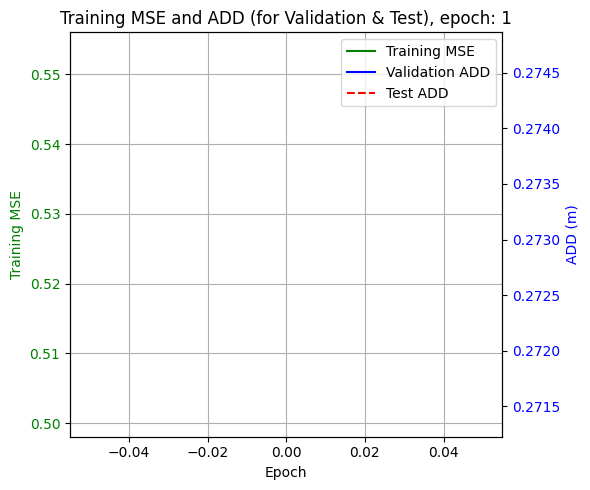


--------- Starting Epoch 2/50 ---------
>>>>>>>Current best ADD is 0.2747<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 2 | Loss: 0.456826 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:30,  1.17s/it]


X loss:           0.000000
Y loss:           0.000009
Z loss:           0.004099
Rotation loss:    0.076596
Total loss:       0.080705
Angular error (deg): 30.20


Validation Loss: 0.506119, Avg ADD: 0.1683


Test Loss: 0.516867, Test ADD: 0.1654
✅ New best ADD: 0.1683 (saved model locally)
☁️ New best ADD: 0.1683 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 2/50 | Validation ADD: 0.1683


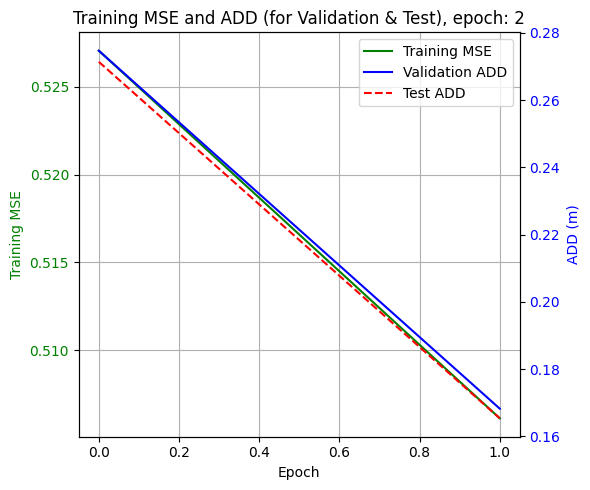


--------- Starting Epoch 3/50 ---------
>>>>>>>Current best ADD is 0.1683<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 3 | Loss: 0.446817 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:46,  1.22s/it]


X loss:           0.000000
Y loss:           0.000015
Z loss:           0.002902
Rotation loss:    0.069438
Total loss:       0.072354
Angular error (deg): 29.08


Validation Loss: 0.503809, Avg ADD: 0.1470


Test Loss: 0.513687, Test ADD: 0.1439
✅ New best ADD: 0.1470 (saved model locally)
☁️ New best ADD: 0.1470 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 3/50 | Validation ADD: 0.1470


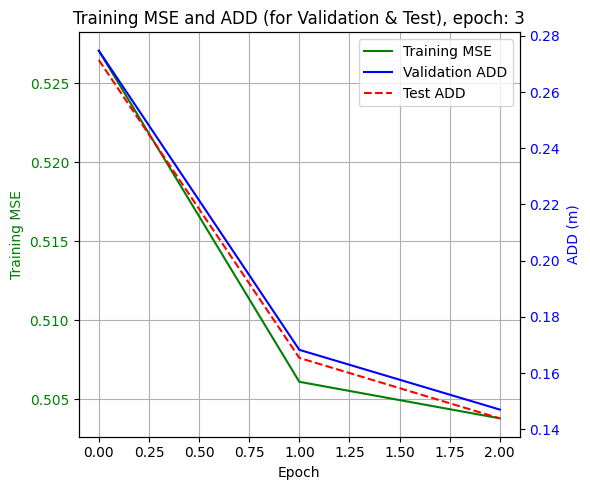


--------- Starting Epoch 4/50 ---------
>>>>>>>Current best ADD is 0.1470<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 4 | Loss: 0.444346 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:21,  1.14s/it]


X loss:           0.000000
Y loss:           0.000023
Z loss:           0.002329
Rotation loss:    0.074224
Total loss:       0.076576
Angular error (deg): 30.20


Validation Loss: 0.499299, Avg ADD: 0.1772


Test Loss: 0.508257, Test ADD: 0.1782
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 4/50 | Validation ADD: 0.1772


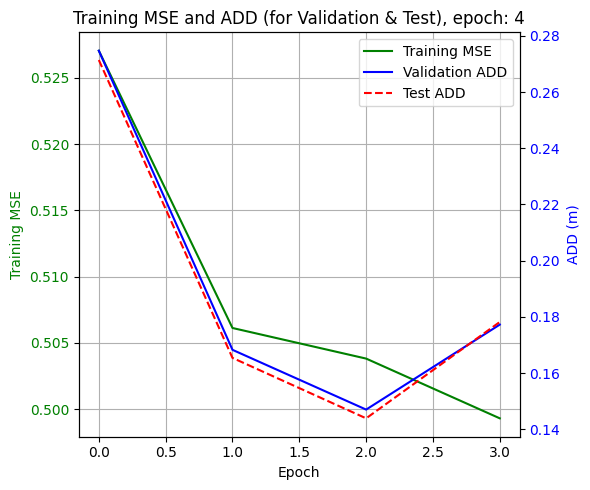


--------- Starting Epoch 5/50 ---------
>>>>>>>Current best ADD is 0.1470<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 5 | Loss: 2.177783 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:29,  1.17s/it]


X loss:           0.000000
Y loss:           0.000027
Z loss:           0.002063
Rotation loss:    0.068460
Total loss:       0.070550
Angular error (deg): 26.95


Validation Loss: 0.501322, Avg ADD: 0.1401


Test Loss: 0.504846, Test ADD: 0.1377
✅ New best ADD: 0.1401 (saved model locally)
☁️ New best ADD: 0.1401 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 5/50 | Validation ADD: 0.1401


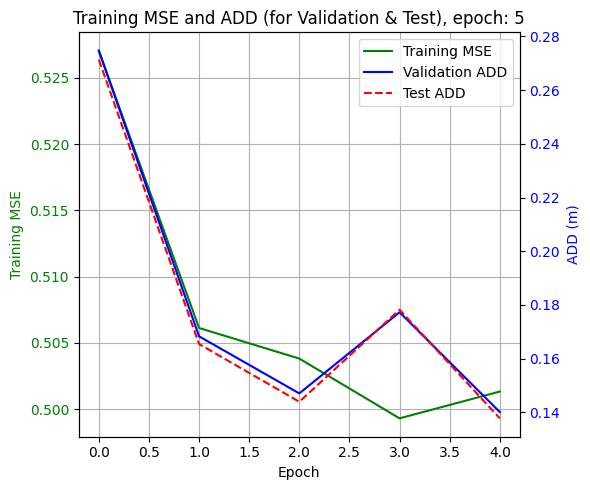


--------- Starting Epoch 6/50 ---------
>>>>>>>Current best ADD is 0.1401<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 6 | Loss: 2.157090 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:19,  1.13s/it]


X loss:           0.000000
Y loss:           0.000018
Z loss:           0.002836
Rotation loss:    0.119190
Total loss:       0.122044
Angular error (deg): 39.41


Validation Loss: 0.544609, Avg ADD: 0.1991


Test Loss: 0.554525, Test ADD: 0.1977
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 6/50 | Validation ADD: 0.1991


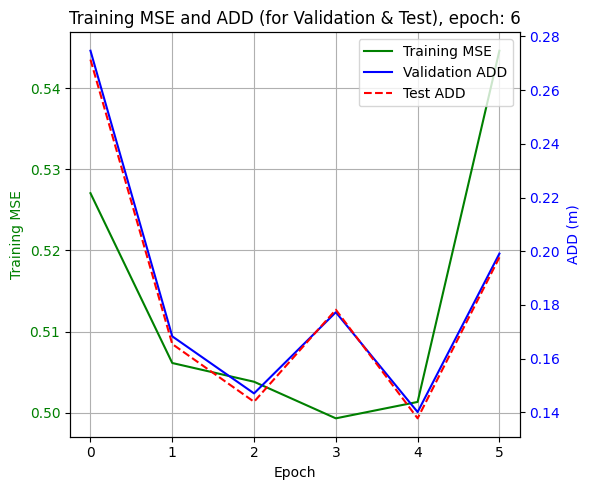


--------- Starting Epoch 7/50 ---------
>>>>>>>Current best ADD is 0.1401<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 7 | Loss: 2.211139 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:17,  1.13s/it]


X loss:           0.000000
Y loss:           0.000035
Z loss:           0.001616
Rotation loss:    0.061592
Total loss:       0.063243
Angular error (deg): 26.43


Validation Loss: 0.502128, Avg ADD: 0.1393


Test Loss: 0.504060, Test ADD: 0.1370
✅ New best ADD: 0.1393 (saved model locally)
☁️ New best ADD: 0.1393 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 7/50 | Validation ADD: 0.1393


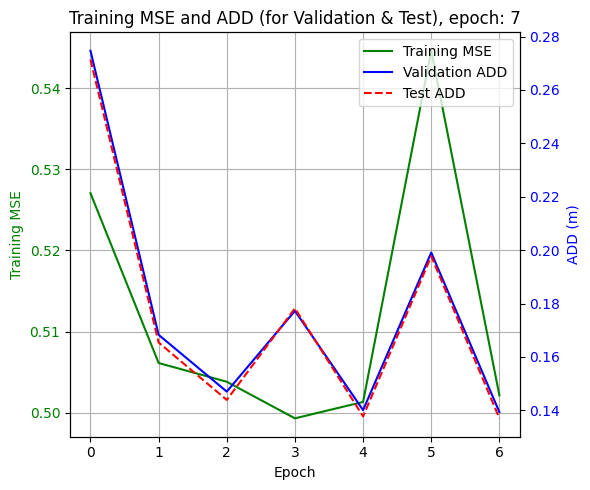


--------- Starting Epoch 8/50 ---------
>>>>>>>Current best ADD is 0.1393<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 8 | Loss: 2.167011 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.11s/it]


X loss:           0.000000
Y loss:           0.000026
Z loss:           0.002173
Rotation loss:    0.070745
Total loss:       0.072944
Angular error (deg): 28.08


Validation Loss: 0.501200, Avg ADD: 0.1352


Test Loss: 0.505261, Test ADD: 0.1333
✅ New best ADD: 0.1352 (saved model locally)
☁️ New best ADD: 0.1352 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 8/50 | Validation ADD: 0.1352


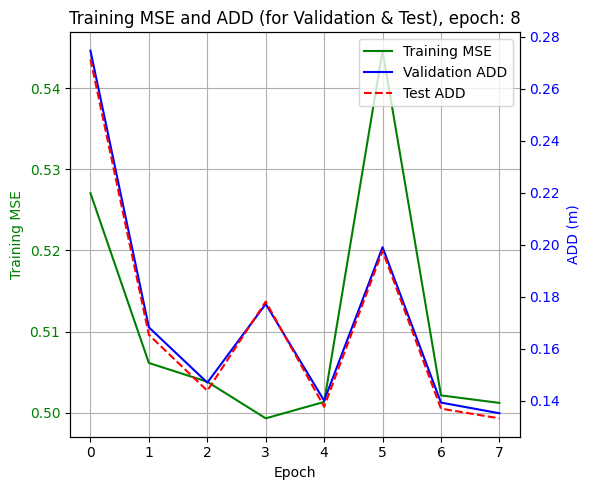


--------- Starting Epoch 9/50 ---------
>>>>>>>Current best ADD is 0.1352<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 9 | Loss: 2.116978 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.11s/it]


X loss:           0.000000
Y loss:           0.000139
Z loss:           0.016002
Rotation loss:    0.161624
Total loss:       0.177765
Angular error (deg): 45.64


Validation Loss: 0.493913, Avg ADD: 0.2219


Test Loss: 0.503525, Test ADD: 0.2218
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 9/50 | Validation ADD: 0.2219


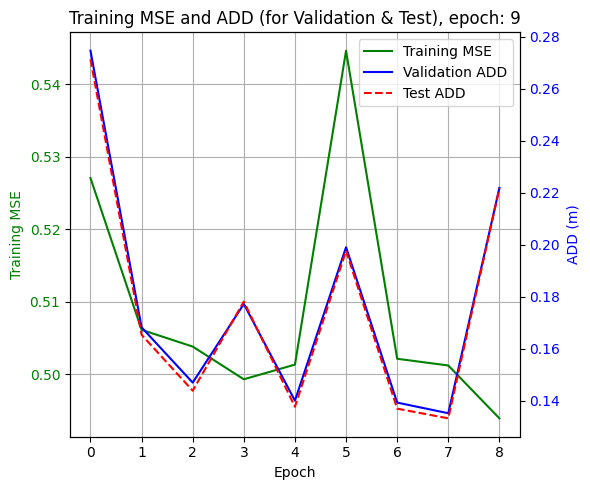


--------- Starting Epoch 10/50 ---------
>>>>>>>Current best ADD is 0.1352<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 10 | Loss: 4.339697 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:17,  1.13s/it]


X loss:           0.000000
Y loss:           0.000032
Z loss:           0.001913
Rotation loss:    0.066895
Total loss:       0.068840
Angular error (deg): 27.36


Validation Loss: 0.502180, Avg ADD: 0.1356


Test Loss: 0.502459, Test ADD: 0.1333
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 10/50 | Validation ADD: 0.1356


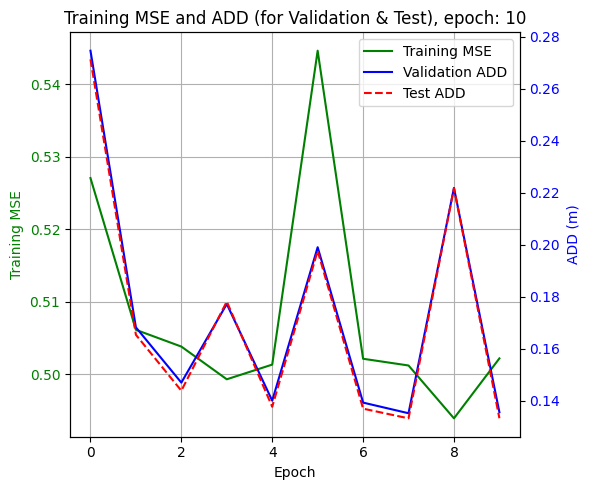


--------- Starting Epoch 11/50 ---------
>>>>>>>Current best ADD is 0.1352<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 11 | Loss: 4.259040 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:34,  1.18s/it]


X loss:           0.000000
Y loss:           0.000008
Z loss:           0.004589
Rotation loss:    0.068777
Total loss:       0.073374
Angular error (deg): 27.54


Validation Loss: 0.500303, Avg ADD: 0.1413


Test Loss: 0.500948, Test ADD: 0.1383
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 11/50 | Validation ADD: 0.1413


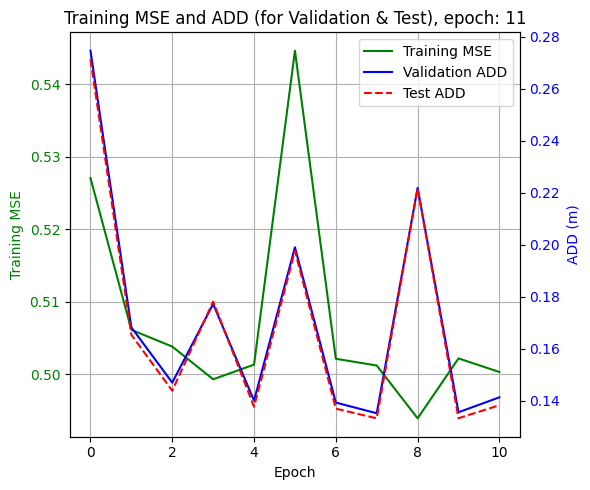


--------- Starting Epoch 12/50 ---------
>>>>>>>Current best ADD is 0.1352<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 12 | Loss: 4.303923 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:17,  1.13s/it]


X loss:           0.000000
Y loss:           0.000033
Z loss:           0.001893
Rotation loss:    0.135849
Total loss:       0.137775
Angular error (deg): 40.38


Validation Loss: 0.497242, Avg ADD: 0.1379


Test Loss: 0.496508, Test ADD: 0.1355
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 12/50 | Validation ADD: 0.1379


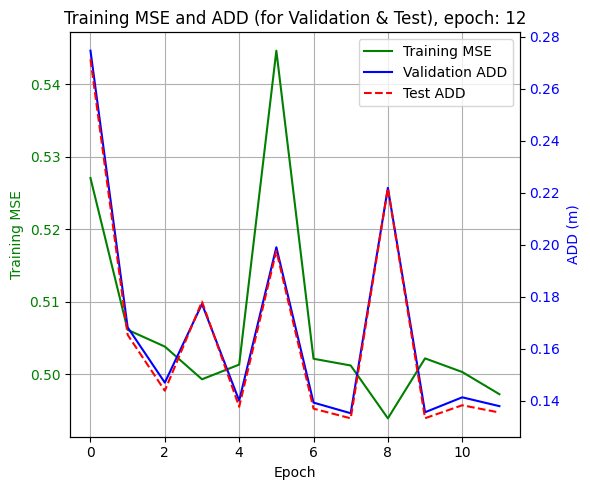


--------- Starting Epoch 13/50 ---------
>>>>>>>Current best ADD is 0.1352<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 13 | Loss: 4.203991 | LR: 0.000100


Evaluating:   0%|          | 0/335 [00:00<?, ?it/s]


X loss:           0.000000
Y loss:           0.000007
Z loss:           0.003790
Rotation loss:    0.091104
Total loss:       0.094901
Angular error (deg): 31.20


Validation Loss: 0.493191, Avg ADD: 0.1336


Test Loss: 0.496763, Test ADD: 0.1310
✅ New best ADD: 0.1336 (saved model locally)
☁️ New best ADD: 0.1336 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 13/50 | Validation ADD: 0.1336


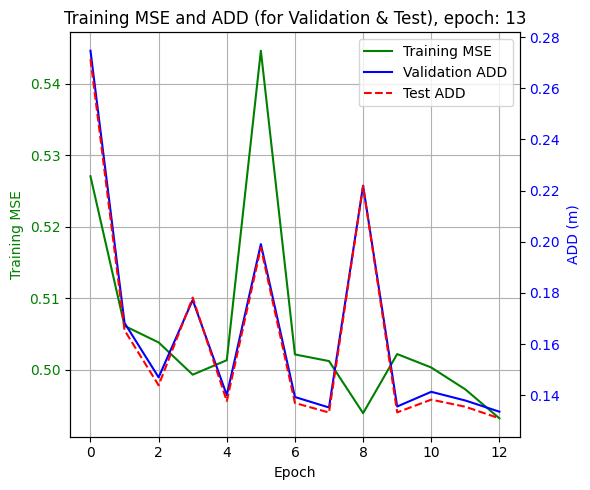


--------- Starting Epoch 14/50 ---------
>>>>>>>Current best ADD is 0.1336<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 14 | Loss: 4.145641 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:22,  1.14s/it]


X loss:           0.000000
Y loss:           0.000011
Z loss:           0.003997
Rotation loss:    0.063848
Total loss:       0.067856
Angular error (deg): 25.78


Validation Loss: 0.489161, Avg ADD: 0.1289


Test Loss: 0.492129, Test ADD: 0.1271
✅ New best ADD: 0.1289 (saved model locally)
☁️ New best ADD: 0.1289 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 14/50 | Validation ADD: 0.1289


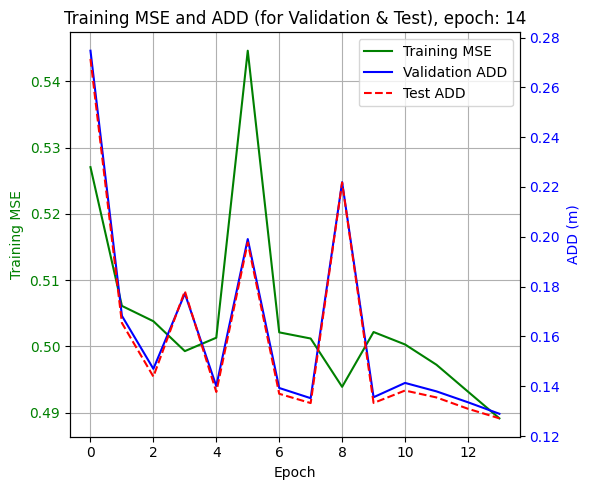


--------- Starting Epoch 15/50 ---------
>>>>>>>Current best ADD is 0.1289<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 15 | Loss: 4.099083 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<07:34,  1.36s/it]


X loss:           0.000000
Y loss:           0.000038
Z loss:           0.004113
Rotation loss:    0.071676
Total loss:       0.075827
Angular error (deg): 27.75


Validation Loss: 0.476430, Avg ADD: 0.1281


Test Loss: 0.481753, Test ADD: 0.1263
✅ New best ADD: 0.1281 (saved model locally)
☁️ New best ADD: 0.1281 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 15/50 | Validation ADD: 0.1281


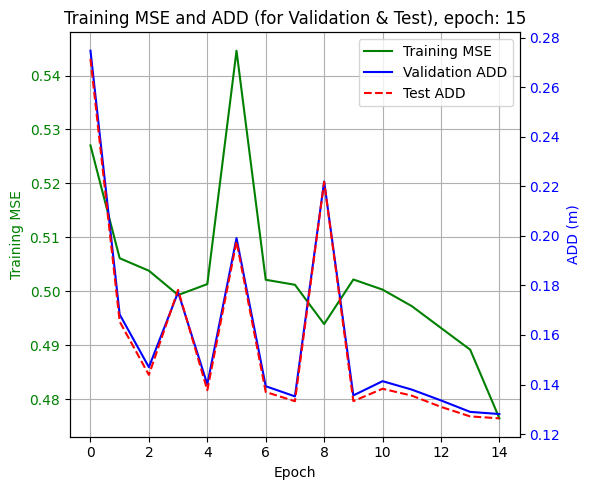


--------- Starting Epoch 16/50 ---------
>>>>>>>Current best ADD is 0.1281<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 16 | Loss: 4.052638 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:23,  1.15s/it]


X loss:           0.000000
Y loss:           0.000040
Z loss:           0.003655
Rotation loss:    0.058582
Total loss:       0.062277
Angular error (deg): 25.28


Validation Loss: 0.467990, Avg ADD: 0.1241


Test Loss: 0.471953, Test ADD: 0.1223
✅ New best ADD: 0.1241 (saved model locally)
☁️ New best ADD: 0.1241 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 16/50 | Validation ADD: 0.1241


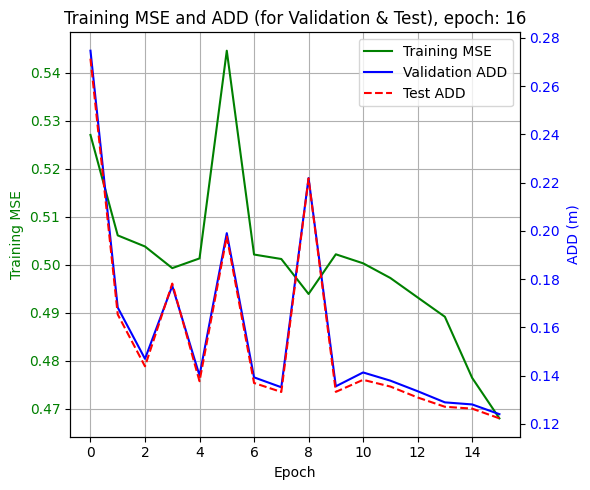


--------- Starting Epoch 17/50 ---------
>>>>>>>Current best ADD is 0.1241<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 17 | Loss: 3.992965 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:02<11:08,  2.00s/it]


X loss:           0.000000
Y loss:           0.000047
Z loss:           0.002483
Rotation loss:    0.059295
Total loss:       0.061825
Angular error (deg): 24.96


Validation Loss: 0.460309, Avg ADD: 0.1261


Test Loss: 0.466587, Test ADD: 0.1248
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 17/50 | Validation ADD: 0.1261


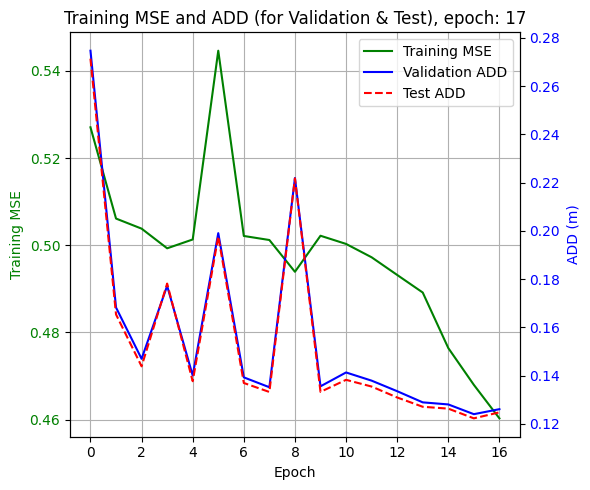


--------- Starting Epoch 18/50 ---------
>>>>>>>Current best ADD is 0.1241<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 18 | Loss: 3.921349 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<07:51,  1.41s/it]


X loss:           0.000000
Y loss:           0.000019
Z loss:           0.003630
Rotation loss:    0.061628
Total loss:       0.065277
Angular error (deg): 25.74


Validation Loss: 0.454149, Avg ADD: 0.1195


Test Loss: 0.459742, Test ADD: 0.1181
✅ New best ADD: 0.1195 (saved model locally)
☁️ New best ADD: 0.1195 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 18/50 | Validation ADD: 0.1195


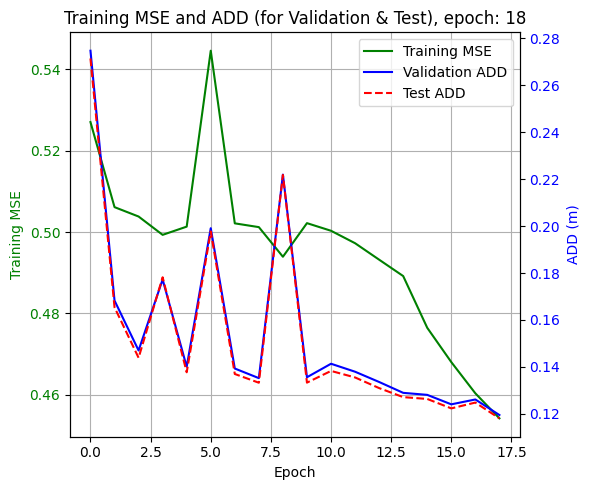


--------- Starting Epoch 19/50 ---------
>>>>>>>Current best ADD is 0.1195<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 19 | Loss: 3.787103 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<08:09,  1.47s/it]


X loss:           0.000000
Y loss:           0.000047
Z loss:           0.002268
Rotation loss:    0.069919
Total loss:       0.072234
Angular error (deg): 26.62


Validation Loss: 0.427276, Avg ADD: 0.1225


Test Loss: 0.431589, Test ADD: 0.1216
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 19/50 | Validation ADD: 0.1225


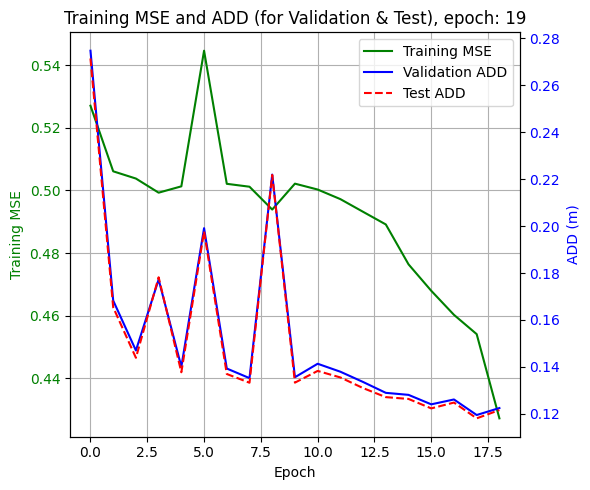


--------- Starting Epoch 20/50 ---------
>>>>>>>Current best ADD is 0.1195<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 20 | Loss: 3.775804 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<08:16,  1.49s/it]


X loss:           0.000000
Y loss:           0.000063
Z loss:           0.001509
Rotation loss:    0.068257
Total loss:       0.069829
Angular error (deg): 26.71


Validation Loss: 0.436443, Avg ADD: 0.1185


Test Loss: 0.435779, Test ADD: 0.1165
✅ New best ADD: 0.1185 (saved model locally)
☁️ New best ADD: 0.1185 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 20/50 | Validation ADD: 0.1185


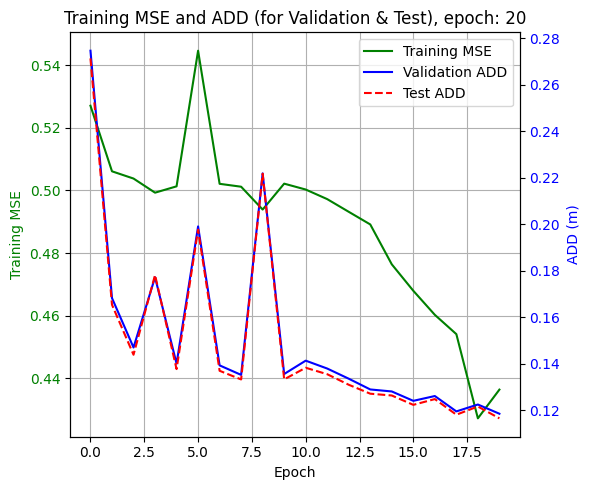


--------- Starting Epoch 21/50 ---------
>>>>>>>Current best ADD is 0.1185<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 21 | Loss: 3.721906 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:14,  1.12s/it]


X loss:           0.000000
Y loss:           0.000048
Z loss:           0.004988
Rotation loss:    0.074106
Total loss:       0.079142
Angular error (deg): 29.29


Validation Loss: 0.397741, Avg ADD: 0.1147


Test Loss: 0.397351, Test ADD: 0.1134
✅ New best ADD: 0.1147 (saved model locally)
☁️ New best ADD: 0.1147 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 21/50 | Validation ADD: 0.1147


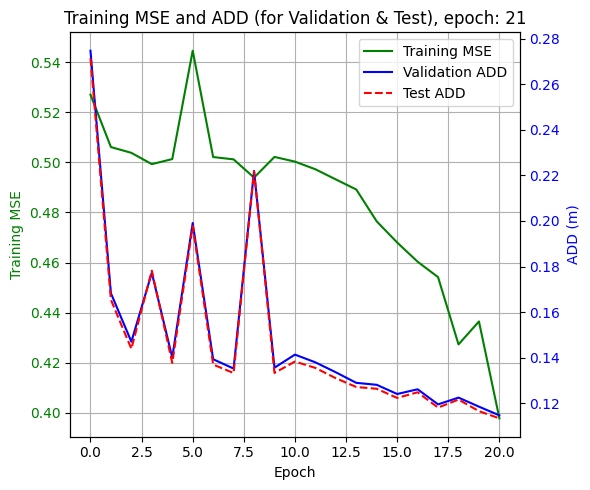


--------- Starting Epoch 22/50 ---------
>>>>>>>Current best ADD is 0.1147<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 22 | Loss: 3.514776 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.11s/it]


X loss:           0.000000
Y loss:           0.000449
Z loss:           0.003753
Rotation loss:    0.072609
Total loss:       0.076811
Angular error (deg): 28.44


Validation Loss: 0.383259, Avg ADD: 0.1306


Test Loss: 0.386102, Test ADD: 0.1312
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 22/50 | Validation ADD: 0.1306


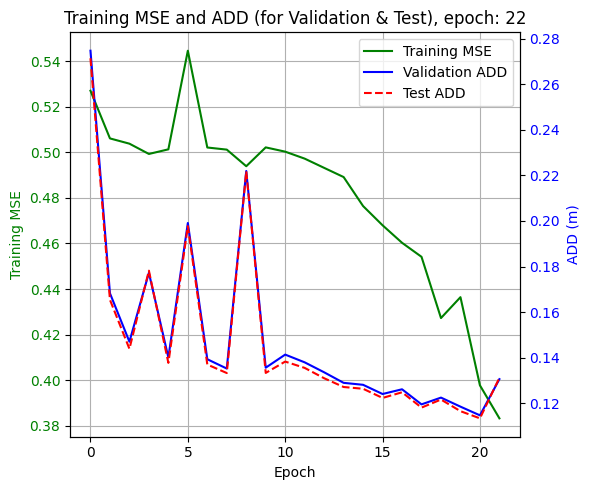


--------- Starting Epoch 23/50 ---------
>>>>>>>Current best ADD is 0.1147<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 23 | Loss: 3.357536 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:57,  1.25s/it]


X loss:           0.000000
Y loss:           0.000012
Z loss:           0.004270
Rotation loss:    0.078857
Total loss:       0.083139
Angular error (deg): 28.74


Validation Loss: 0.358502, Avg ADD: 0.1082


Test Loss: 0.362961, Test ADD: 0.1066
✅ New best ADD: 0.1082 (saved model locally)
☁️ New best ADD: 0.1082 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 23/50 | Validation ADD: 0.1082


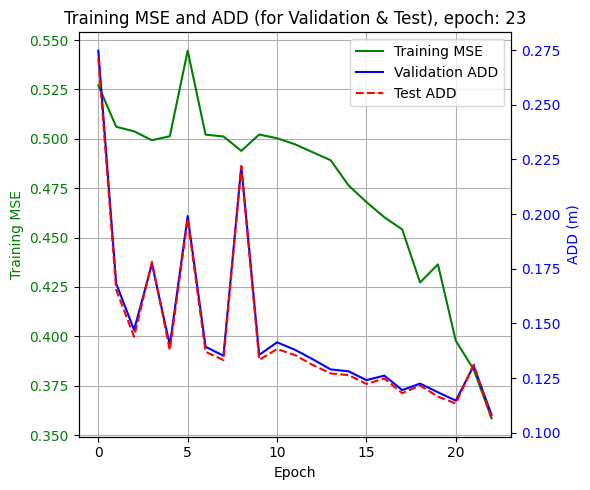


--------- Starting Epoch 24/50 ---------
>>>>>>>Current best ADD is 0.1082<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 24 | Loss: 3.234726 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:02<13:40,  2.46s/it]


X loss:           0.000000
Y loss:           0.000064
Z loss:           0.001038
Rotation loss:    0.074395
Total loss:       0.075496
Angular error (deg): 28.35


Validation Loss: 0.344219, Avg ADD: 0.1085


Test Loss: 0.354826, Test ADD: 0.1075
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 24/50 | Validation ADD: 0.1085


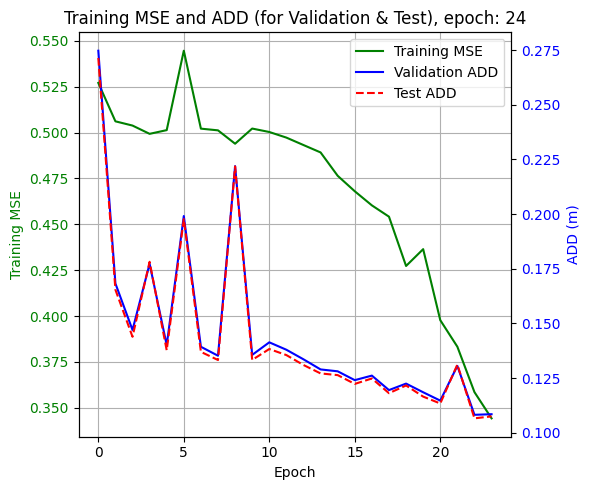


--------- Starting Epoch 25/50 ---------
>>>>>>>Current best ADD is 0.1082<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 25 | Loss: 3.198204 | LR: 0.000100


Evaluating:   1%|          | 2/335 [00:01<03:28,  1.59it/s]


X loss:           0.000000
Y loss:           0.000030
Z loss:           0.002423
Rotation loss:    0.084843
Total loss:       0.087296
Angular error (deg): 30.50


Validation Loss: 0.354001, Avg ADD: 0.1140


Test Loss: 0.359549, Test ADD: 0.1126
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 25/50 | Validation ADD: 0.1140


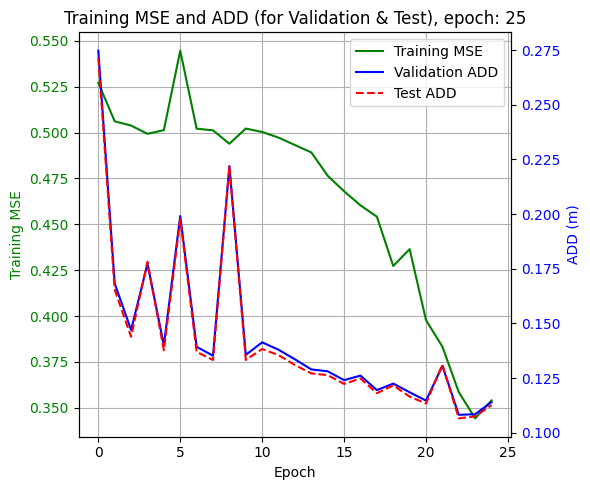


--------- Starting Epoch 26/50 ---------
>>>>>>>Current best ADD is 0.1082<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 26 | Loss: 3.111602 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<09:06,  1.64s/it]


X loss:           0.000000
Y loss:           0.000043
Z loss:           0.003142
Rotation loss:    0.100308
Total loss:       0.103493
Angular error (deg): 33.74


Validation Loss: 0.337762, Avg ADD: 0.1096


Test Loss: 0.349527, Test ADD: 0.1089
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 26/50 | Validation ADD: 0.1096


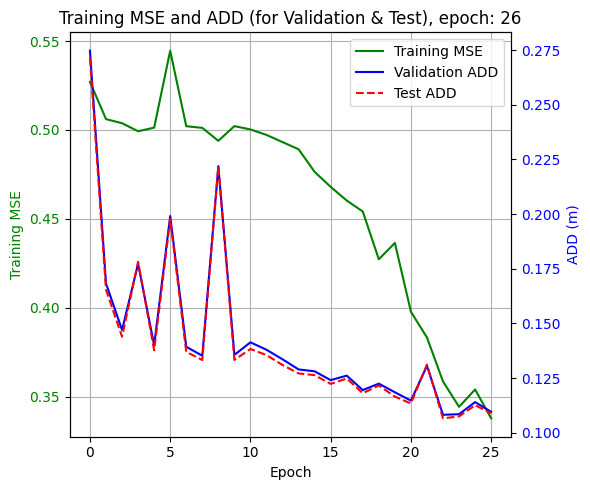


--------- Starting Epoch 27/50 ---------
>>>>>>>Current best ADD is 0.1082<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 27 | Loss: 3.244838 | LR: 0.000100


Evaluating:   1%|          | 2/335 [00:01<03:03,  1.81it/s]


X loss:           0.000000
Y loss:           0.000064
Z loss:           0.019454
Rotation loss:    0.070823
Total loss:       0.090340
Angular error (deg): 27.17


Validation Loss: 0.357067, Avg ADD: 0.1237


Test Loss: 0.364253, Test ADD: 0.1246
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 27/50 | Validation ADD: 0.1237


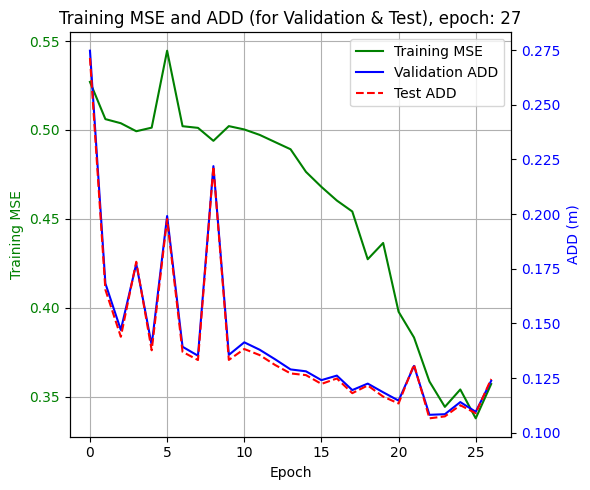


--------- Starting Epoch 28/50 ---------
>>>>>>>Current best ADD is 0.1082<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 28 | Loss: 2.976050 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:40,  1.20s/it]


X loss:           0.000000
Y loss:           0.000033
Z loss:           0.002879
Rotation loss:    0.076306
Total loss:       0.079218
Angular error (deg): 28.42


Validation Loss: 0.324541, Avg ADD: 0.0960


Test Loss: 0.332812, Test ADD: 0.0947
✅ New best ADD: 0.0960 (saved model locally)
☁️ New best ADD: 0.0960 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 28/50 | Validation ADD: 0.0960


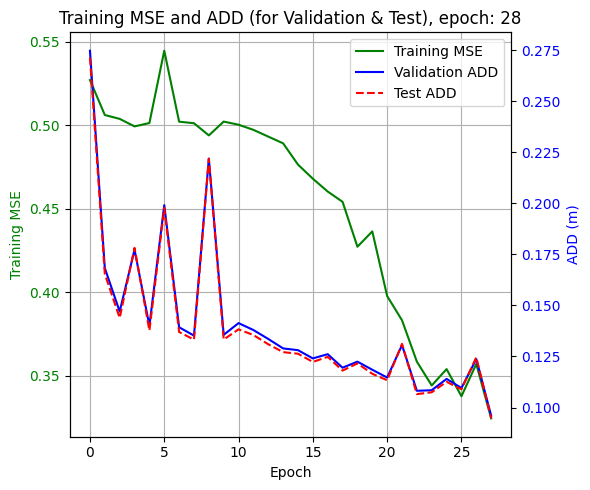


--------- Starting Epoch 29/50 ---------
>>>>>>>Current best ADD is 0.0960<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 29 | Loss: 2.963773 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:41,  1.20s/it]


X loss:           0.000000
Y loss:           0.000023
Z loss:           0.002558
Rotation loss:    0.073650
Total loss:       0.076230
Angular error (deg): 27.72


Validation Loss: 0.324250, Avg ADD: 0.0959


Test Loss: 0.332771, Test ADD: 0.0950
✅ New best ADD: 0.0959 (saved model locally)
☁️ New best ADD: 0.0959 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 29/50 | Validation ADD: 0.0959


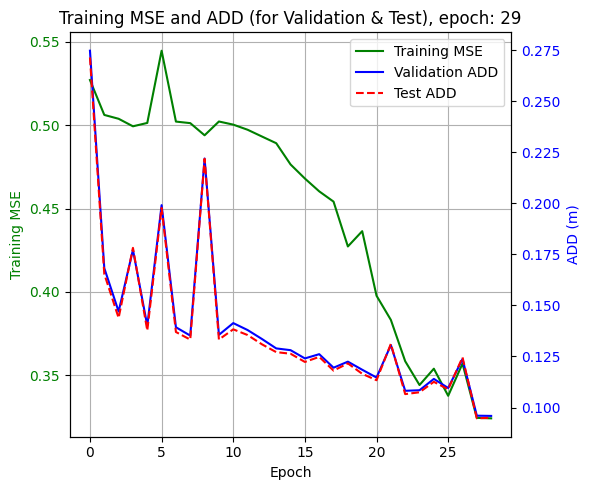


--------- Starting Epoch 30/50 ---------
>>>>>>>Current best ADD is 0.0959<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 30 | Loss: 2.938733 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:23,  1.15s/it]


X loss:           0.000000
Y loss:           0.000035
Z loss:           0.002024
Rotation loss:    0.065758
Total loss:       0.067817
Angular error (deg): 26.65


Validation Loss: 0.320760, Avg ADD: 0.0942


Test Loss: 0.330344, Test ADD: 0.0933
✅ New best ADD: 0.0942 (saved model locally)
☁️ New best ADD: 0.0942 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 30/50 | Validation ADD: 0.0942


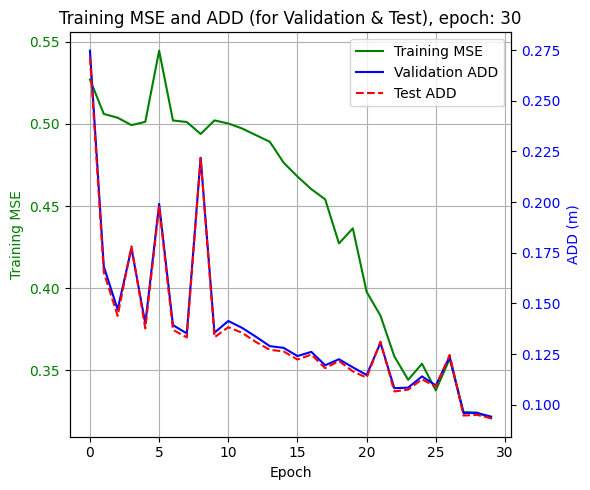


--------- Starting Epoch 31/50 ---------
>>>>>>>Current best ADD is 0.0942<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 31 | Loss: 2.888780 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:34,  1.18s/it]


X loss:           0.000000
Y loss:           0.000041
Z loss:           0.002317
Rotation loss:    0.064980
Total loss:       0.067337
Angular error (deg): 26.27


Validation Loss: 0.319484, Avg ADD: 0.0946


Test Loss: 0.326268, Test ADD: 0.0933
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 31/50 | Validation ADD: 0.0946


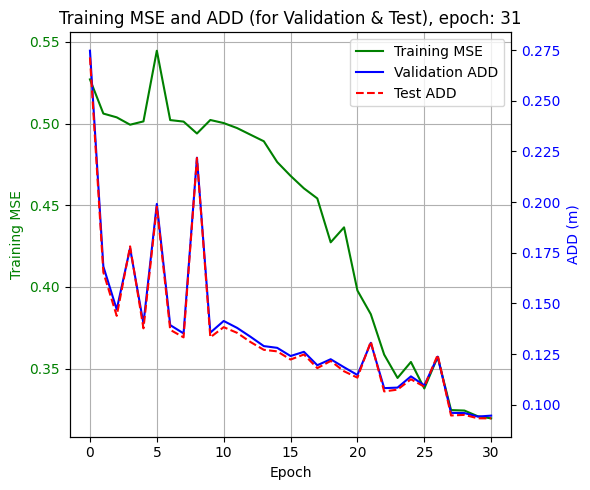


--------- Starting Epoch 32/50 ---------
>>>>>>>Current best ADD is 0.0942<<<<<<<<<
Invalid samples found in dataset: 0


Epoch 32 | Loss: 2.915096 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:41,  1.20s/it]


X loss:           0.000000
Y loss:           0.000025
Z loss:           0.003077
Rotation loss:    0.071100
Total loss:       0.074201
Angular error (deg): 27.58


Validation Loss: 0.317575, Avg ADD: 0.0938


Test Loss: 0.326869, Test ADD: 0.0925
✅ New best ADD: 0.0938 (saved model locally)
☁️ New best ADD: 0.0938 (saved model on Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved on Google Drive.
Epoch 32/50 | Validation ADD: 0.0938


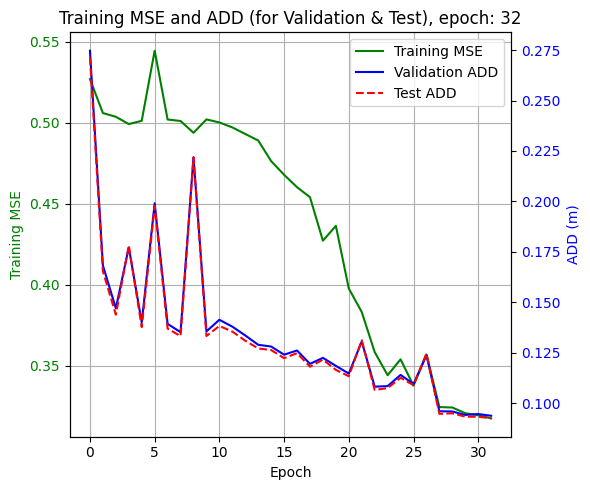


--------- Starting Epoch 33/50 ---------
>>>>>>>Current best ADD is 0.0938<<<<<<<<<
Invalid samples found in dataset: 0


KeyboardInterrupt: 

In [ ]:
# Flags to control where checkpoints are saved.
SAVE_LOCAL = True
SAVE_DRIVE = True

# Determining the number of objects in dataset.
_, num_objects = train_dataset.getMappedIDs()
num_obj = len(num_objects)
print(f"This model will be trained to find {num_obj} object(s).")

# Initialize model and launch training.
model = PoseNet6D(num_objects=num_obj)

model ,_ ,_ = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    full_project_path=full_project_path,
    num_epochs=50,
    patience=10
)

## Functions for plotting the results

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# === Drawing Functions ===

def draw_model_projection(image, points, color, radius=1):
    """
    Draws 2D projected 3D model points on the image.

    Args:
        image (ndarray): Image to draw on.
        points (ndarray): 2D points (N, 2).
        color (tuple): BGR color.
        radius (int): Radius of circles to draw.
    """
    for pt in points.astype(int):
        x, y = pt
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            cv2.circle(image, (x, y), radius, color, -1)

def draw_legend(image, labels_colors):
    """
    Draws a legend box on the image showing labels and colors.

    Args:
        image (ndarray): Image to draw on.
        labels_colors (list): List of tuples: (label, BGR color).
    """
    x, y, spacing = 10, 25, 25
    font_scale = 0.4
    text_thickness = 1
    box_width, box_height = 10, 10
    for i, (label, color) in enumerate(labels_colors):
        cv2.putText(image, label, (x + box_width + 5, y + i * spacing),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, text_thickness)
        cv2.rectangle(image,
                      (x, y - box_height // 2 + i * spacing),
                      (x + box_width, y + box_height // 2 + i * spacing),
                      color, -1)

def draw_axes(image, R, t, K, is_gt=False, axis_length=0.05, thickness=2):
    """
    Draws 3D coordinate axes projected into the image.

    Args:
        image (ndarray): Image to draw on.
        R (ndarray): 3x3 rotation matrix.
        t (ndarray): 3D translation vector.
        K (ndarray): Camera intrinsic matrix.
        is_gt (bool): Whether this is ground truth or prediction.
        axis_length (float): Length of each axis in meters.
        thickness (int): Line thickness.

    Returns:
        ndarray: Modified image.
    """
    axes_3d = np.array([
        [0, 0, 0],
        [axis_length, 0, 0],
        [0, axis_length, 0],
        [0, 0, axis_length]
    ], dtype=np.float32)

    pts_2d = (K @ (axes_3d @ R.T + t).T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    pts_2d = pts_2d.astype(int)

    o = tuple(pts_2d[0])
    cv2.circle(image, o, 6, (255, 255, 255), -1)

    # Use light colors for GT, strong for prediction
    color_map = [(0, 0, 255), (0, 255, 0), (255, 0, 0)] if not is_gt else \
                [(100, 100, 255), (100, 255, 100), (255, 100, 100)]
    for i in range(1, 4):
        cv2.line(image, o, tuple(pts_2d[i]), color_map[i - 1], thickness)

    return image

def project(pts, R, t, K):
    """
    Projects 3D points onto the 2D image plane using the given pose and intrinsics.
    """
    proj = (K @ (pts @ R.T + t).T).T
    return proj[:, :2] / proj[:, 2:3]

# === Pose Visualization for a Single Object ===

def visualize_pose_prediction(obj, model, dataset, obj_id, device,
                              draw_axes_flag=False, draw_models=True, use_full_frame=True,
                              save_dir=None, save_prefix="result", legend=False):
    """
    Visualizes the predicted and ground truth poses for one object.

    Args:
        obj (dict): One object entry from a dataset item.
        model (nn.Module): Trained pose estimation model.
        dataset: PoseEstimationDataset instance.
        obj_id (int): Mapped object ID.
        device: Device for inference.
        draw_axes_flag (bool): Draw X Y Z axes for pose.
        draw_models (bool): Project model points.
        use_full_frame (bool): Show full image view too.
        save_dir (str): Directory to save image (optional).
        save_prefix (str): Prefix for output filenames.
        legend (bool): Whether to draw the legend.
    """
    # === Preparing the model inputs ===
    rgb = obj['cropped_rgb'].unsqueeze(0).to(device)
    norm_bbox = obj['norm_bbox'].unsqueeze(0).to(device)
    cropped_K = obj['cropped_K'].unsqueeze(0).to(device)
    obj_tensor = torch.tensor([obj_id], dtype=torch.long).to(device)

    R_gt = obj['rotation']
    t_gt = obj['translation']

    # === Inference ===
    with torch.no_grad():
        t_pred, quat_pred = model(rgb, norm_bbox, cropped_K, obj_tensor)

    R_pred = quaternion_to_matrix_batch(quat_pred.detach()).squeeze().cpu().numpy()
    t_pred = t_pred.detach().squeeze().cpu().numpy()

    # Compute angular error (GT quaternion).
    quat_gt = matrix_to_quaternion_batch(torch.tensor(R_gt, dtype=torch.float32).to(device))
    with torch.no_grad():
        ang_err = quaternion_angular_error(quat_pred, quat_gt).item()

    # Get original object ID and model.
    original_id = dataset.idx_to_id[obj_id]
    model_points = dataset.load_3D_model(original_id)

    # === Cropped image view ===
    crop_rgb = obj['cropped_rgb'].cpu().numpy().transpose(1, 2, 0)
    crop_rgb = ((crop_rgb * 0.229 + 0.485).clip(0, 1) * 255).astype(np.uint8)
    crop_rgb = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2BGR)
    cropped_K_np = cropped_K.squeeze().cpu().numpy()

    vis_crop = crop_rgb.copy()

    # Draw axes.
    if draw_axes_flag:
        vis_crop = draw_axes(vis_crop, R_pred, t_pred, cropped_K_np)
        vis_crop = draw_axes(vis_crop, R_gt, t_gt, cropped_K_np, is_gt=True)

    # Draw 3d-models.
    if draw_models:
        draw_model_projection(vis_crop, project(model_points, R_gt, t_gt, cropped_K_np), (0, 255, 0))
        draw_model_projection(vis_crop, project(model_points, R_pred, t_pred, cropped_K_np), (0, 0, 255))

    # Draw legend.
    if legend:
        draw_legend(vis_crop, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])

    # Computing the ADD metric.
    add = computeADD(R_pred, t_pred, R_gt, t_gt, model_points)
    print(f"\n➡️ Mapped object ID {obj_id:02d}")
    print(f"ADD: {add:.4f} m | Angular Error: {ang_err:.2f}°")

    # Showing cropped result.
    plt.figure()
    plt.imshow(cv2.cvtColor(vis_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"[Cropped] Obj {original_id:02d}")
    plt.axis("off")
    plt.show()

    # Optionally save.
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        cv2.imwrite(os.path.join(save_dir, f"{save_prefix}_cropped_obj{obj_id:02d}.png"), vis_crop)

    # === Full image view ===
    if use_full_frame:
        full_image = cv2.cvtColor(np.array(obj['original_rgb']), cv2.COLOR_RGB2BGR)
        original_K = obj['original_K'].numpy()

        if draw_axes_flag:
            full_image = draw_axes(full_image, R_pred, t_pred, original_K)
            full_image = draw_axes(full_image, R_gt, t_gt, original_K, is_gt=True)
        if draw_models:
            draw_model_projection(full_image, project(model_points, R_gt, t_gt, original_K), (0, 255, 0))
            draw_model_projection(full_image, project(model_points, R_pred, t_pred, original_K), (0, 0, 255))
        if legend:
            draw_legend(full_image, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])

        plt.figure()
        plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
        plt.title(f"[Full Frame] Obj {original_id:02d}")
        plt.axis("off")
        plt.show()

        if save_dir:
            cv2.imwrite(os.path.join(save_dir, f"{save_prefix}_fullframe_obj{obj_id:02d}.png"), full_image)

# === Visualization Launcher for a Dataset Item ===

def run_visualization(model, dataset, device, target_obj_ids,
                      img_idx=0, save_dir=None, draw_axes=False,
                      draw_legend=False, draw_models=False):
    """
    Runs visualization on one image sample and selected object IDs.

    Args:
        model (nn.Module): Trained pose model.
        dataset: Dataset containing objects.
        device: Device for inference.
        target_obj_ids (list): Mapped object IDs to visualize.
        img_idx (int): Index of the image in the dataset.
        save_dir (str): Output directory for saving visualizations.
        draw_axes (bool): Whether to draw pose axes.
        draw_legend (bool): Whether to draw a legend.
        draw_models (bool): Whether to project model points.
    """
    model.eval()
    idx_to_id = {v: k for k, v in dataset.id_to_idx.items()}

    with torch.no_grad():
        data_item = dataset[img_idx]
        found_obj_ids = set()

        # Inject shared data into each object entry.
        for obj in data_item['objects']:
            obj_id = obj['object_id']
            if obj_id in target_obj_ids:
                found_obj_ids.add(obj_id)
                obj['original_rgb'] = data_item['original_rgb']
                obj['original_K'] = data_item['original_K']

                visualize_pose_prediction(
                    obj, model, dataset, obj_id, device,
                    draw_axes_flag=draw_axes,
                    draw_models=draw_models,
                    legend=draw_legend,
                    save_dir=save_dir,
                    save_prefix=f"img{img_idx:03d}_obj{obj_id:02d}"
                )

        # Warn if some requested object IDs were not present in this sample.
        missing_ids = set(target_obj_ids) - found_obj_ids
        if missing_ids:
            missing_original_ids = sorted([idx_to_id[mapped_id] for mapped_id in missing_ids])
            print(f"⚠️ Note: These object IDs (mapped) were not present in image {img_idx}: {sorted(missing_ids)}")

## Plotting the results

In [ ]:
# --- Dataset & Paths ---
dataset_root = os.path.join(full_project_path, 'path/to/data/folder')
models_root = os.path.join(full_project_path, "path/to/models")

# Load a subset (e.g., objects 1 and 13)
folders = [2] # List of folder [1,2,3].
dataset = PoseEstimationDataset(dataset_root,
                                models_root,
                                folders=folders)

In [ ]:
# Printing all original object IDs found in the dataset.
print("✅ Object IDs in dataset:", dataset.object_ids)

# Retrieving mapped internal IDs (used during training).
all_mapped_ids, _ = dataset.getMappedIDs()
print("✅ Mapped IDs:", all_mapped_ids)

# === Select which object IDs you want to visualize ===
# Can be all (1–15) or a subset like [13].
original_ids_to_visualize = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# original_ids_to_visualize = [13]

# === Model Setup ===
# Adjust num_objects to match what the model was trained on.
num_objects = len(original_ids_to_visualize)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize and load the trained model.
model = PoseNet6D(num_objects=13)
model.load_state_dict(torch.load('/content/best_posenet_OP.pt',
                                 map_location=device))
model.to(device)

# === Visualization ===
# Convert selected original object IDs to internal mapped indices.
mapped_ids, _ = dataset.getMappedIDs(original_ids_to_visualize)

img_idx = 15  # Dataset index of the image you want to visualize.
save_dir = "/content/visualizations"  # Where to save the result images.

# === Running the pose visualization ===
run_visualization(
    model=model,
    dataset=dataset,
    device=device,
    target_obj_ids=mapped_ids,  # Use mapped IDs for internal consistency.
    img_idx=img_idx,            # Visualize this specific sample.
    save_dir=save_dir,
    draw_axes=True,             # Show 3D pose axes.
    draw_legend=False,          # Skip legend overlay.
    draw_models=False           # Skip projecting 3D model points.
)